In [1]:
import torch
from torch import nn 
import torchvision
from torchvision import datasets, transforms  
import matplotlib.pyplot as plt



In [44]:
class Attention(nn.Module):  
    def __init__(self, embed_size = 16*16 , heads = 1, dropout=0.2):  
        super(Attention, self).__init__()  
        self.embed_size = embed_size  
        self.heads = heads  
        self.head_dim = embed_size // heads  

        assert (  
            self.head_dim * heads == embed_size  
        ), "Embedding size must be divisible by heads"  

        self.values = nn.Linear(embed_size, embed_size, bias=False)  
        self.keys = nn.Linear(embed_size, embed_size, bias=False)  
        self.queries = nn.Linear(embed_size, embed_size, bias=False)  
        self.fc_out = nn.Linear(embed_size, embed_size)  

        self.dropout = nn.Dropout(dropout)  

    

    def forward(self, x):    
        batch_size, seq_length, embed_size = x.shape  

        values = self.values(x)  # (batch_size, seq_length, embed_size)  
        keys = self.keys(x)      
        queries = self.queries(x)  

       
        # Scaled dot-product attention  
        
        energy = torch.bmm(queries, keys.transpose(-2, -1))  # (batch_size, query_length, key_length)  
        

        # 进行缩放  
        scaling = self.head_dim ** 0.5  
        scaled_energy = energy / scaling  # (batch_size, query_length, key_length)  

        # 应用 softmax  
        attention = nn.functional.softmax(scaled_energy, dim=-1)

        # 计算输出  
        out = torch.bmm(attention, values)  # (batch_size, query_length, head_dim)  
        # 注意：这里的 values 仍然是 (batch_size, heads, seq_length, head_dim)  

    

        # 最后，通过线性层输出  
        out = self.fc_out(out)  
        return self.dropout(out)  
    
class VisionEncoder(nn.Module):  
    def __init__(self, embed_size = 16*16, heads = 1, drop_rate=0.2):  
        super(VisionEncoder, self).__init__()  
        self.attention = Attention(embed_size, heads, dropout=drop_rate)  
        self.norm1 = nn.LayerNorm(embed_size)  
        self.norm2 = nn.LayerNorm(embed_size)  
        self.mlp = nn.Sequential(  
            nn.Linear(embed_size, 2048),  
            nn.GELU(),  
            nn.Dropout(drop_rate),  
            nn.Linear(2048, embed_size),  
            nn.Dropout(drop_rate)  
        )  

    def forward(self, x):  
        attention = self.attention(x)  
        x = self.norm1(attention + x)  # Residual Connection  
        mlp_out = self.mlp(x)  
        x = self.norm2(mlp_out + x)  # Residual Connection  
        return x  

class VisionTransformer(nn.Module):  
    def __init__(self, num_classes = 10, embed_size=16*16, num_layers=3, heads=1, num_patches=14*14, drop_rate=0.2):  
        super(VisionTransformer, self).__init__()  
        self.patch = nn.Conv2d(1,embed_size,16,16)
        self.encoders = nn.ModuleList(  
            [VisionEncoder(embed_size, heads, drop_rate) for _ in range(num_layers)]  
        )  
        self.norm = nn.LayerNorm(embed_size)  
        self.classifier = nn.Linear(embed_size, num_classes)  
        self.dropout = nn.Dropout(drop_rate)  

    def forward(self, x):  
        x = self.patch(x)
        x = x.flatten(2).permute(0,2,1)
        
        for encoder in self.encoders:  
            x = encoder(x)  
        
        x = self.norm(x)  
        x = self.dropout(x)  
        x = x.mean(dim=1)  # Global average pooling  
        return self.classifier(x)  


In [5]:
def draw(epoches,Loss_list,Accuracy_list):
    x1 = range(0, epoches)
    x2 = range(0, epoches)
    y1 = Accuracy_list
    y2 = Loss_list
    plt.subplot(2, 1, 1)
    plt.plot(x1, y1, 'o-')
    plt.title('Test accuracy vs. epoches')
    plt.ylabel('Test accuracy')
    plt.subplot(2, 1, 2)
    plt.plot(x2, y2, '.-')
    plt.xlabel('Test loss vs. epoches')
    plt.ylabel('Test loss')
    plt.show()

In [6]:
transform = transforms.Compose([  
    transforms.Resize((224,224)),  # 将图片调整为32x32  
    transforms.ToTensor(),         # 将图片转为Tensor  
    transforms.Normalize((0.1307,), (0.3081,))  # 进行正则化  
])
train_set = datasets.MNIST(root='F:\\study\\wxg\\3\\mnist', train=True, download=False, transform=transform)  

# 读取已经下载的测试数据集  
test_set = datasets.MNIST(root='F:\\study\\wxg\\3\\mnist', train=False, download=False, transform=transform)  

# 使用 DataLoader 加载数据集  
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)  
testloader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)  
# 检查数据是否加载成功  
for images, labels in trainloader:  
    print(images.shape)  # 输出训练样本的形状  
    print(labels.shape)  # 输出训练标签的形状  
    break  # 只查看第一批数据  

torch.Size([64, 1, 224, 224])
torch.Size([64])


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  


epoch: 1, Train Loss: 2.145295, Train Acc: 0.200660
epoch: 2, Train Loss: 1.993268, Train Acc: 0.254981
epoch: 3, Train Loss: 1.838521, Train Acc: 0.314749
epoch: 4, Train Loss: 1.756918, Train Acc: 0.346915
epoch: 5, Train Loss: 1.623068, Train Acc: 0.398771
epoch: 6, Train Loss: 1.528879, Train Acc: 0.425540
epoch: 7, Train Loss: 1.475895, Train Acc: 0.444180
epoch: 8, Train Loss: 1.428593, Train Acc: 0.463186
epoch: 9, Train Loss: 1.390405, Train Acc: 0.477129
epoch: 10, Train Loss: 1.366781, Train Acc: 0.485941
epoch: 11, Train Loss: 1.337930, Train Acc: 0.497485
epoch: 12, Train Loss: 1.316883, Train Acc: 0.505497
epoch: 13, Train Loss: 1.297674, Train Acc: 0.515725
epoch: 14, Train Loss: 1.277322, Train Acc: 0.521189
epoch: 15, Train Loss: 1.257856, Train Acc: 0.530134
epoch: 16, Train Loss: 1.240954, Train Acc: 0.536197
epoch: 17, Train Loss: 1.222167, Train Acc: 0.544110
epoch: 18, Train Loss: 1.205794, Train Acc: 0.551223
epoch: 19, Train Loss: 1.192374, Train Acc: 0.553388
ep

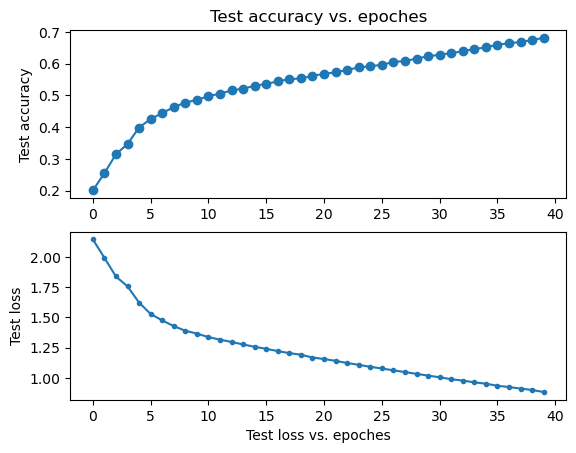

In [48]:

example = VisionTransformer().to(device)
lr = 0.001
epoches = 40
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(example.parameters(),lr=lr)
loss_list = []
accuracy_list = []
loss_list1 = []
accuracy_list1 = []
for epoch in range(epoches):
    train_loss = 0
    train_acc = 0
    for img,label in trainloader:
        img,label = img.to(device),label.to(device)
        output = example(img)
        loss = criterion(output,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _,pred = output.max(1)
        num_correct = (pred==label).sum().item()
        acc = num_correct / img.shape[0]
        train_acc += acc
    loss_list.append(train_loss/len(trainloader))
    accuracy_list.append(train_acc/len(trainloader))
    print('epoch: {}, Train Loss: {:.6f}, Train Acc: {:.6f}'.format(epoch+1, train_loss/len(trainloader), train_acc/len(trainloader)))
draw(epoches,loss_list,accuracy_list)